In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import pandas as pd
import healpy as hp
import time
import warnings
%matplotlib inline

In [2]:
warnings.filterwarnings('ignore')

In [3]:
import camb 

<font size="5">Making a custom power spectrum</font>


Text(0, 0.5, '$D_l$')

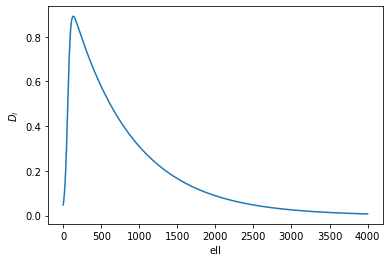

In [4]:
lmax=4000
ell=np.arange(0,lmax+1)

dl=1/(np.exp((60-ell)/20)+np.exp((ell-60)/800))

plt.plot(ell,dl)
plt.xlabel("ell")
plt.ylabel("$D_l$")

Text(0, 0.5, '$ln(D_l)$')

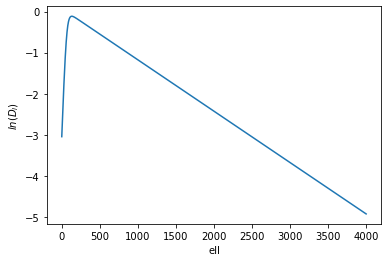

In [5]:
plt.plot(ell,np.log(dl))
plt.xlabel("ell")
plt.ylabel("$ln(D_l)$")

[           inf 2.16000000e+04 1.08000000e+04 ... 5.40270135e+00
 5.40135034e+00 5.40000000e+00]


array([           inf, 2.16000000e+04, 1.08000000e+04, ...,
       5.40270135e+00, 5.40135034e+00, 5.40000000e+00])

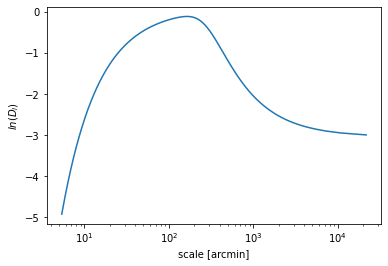

In [13]:
ellsc=21600/ell # scale = 360/ell (deg) = 21600/ell (arcmin)
#ellsc=ellsc[::-1]
print (ellsc)
#fdl=dl[::-1]

plt.plot(ellsc,np.log(dl))
plt.xlabel('scale [arcmin]')
plt.xscale('log')
plt.ylabel('$ln(D_l)$')
ellsc

In [10]:
cl = dl * 2 * np.pi / (ell*(ell+1.))
cl[0]=0
cl[1]=0

In [11]:
lmax

4000

<font size="5">Making a full sky map</font>


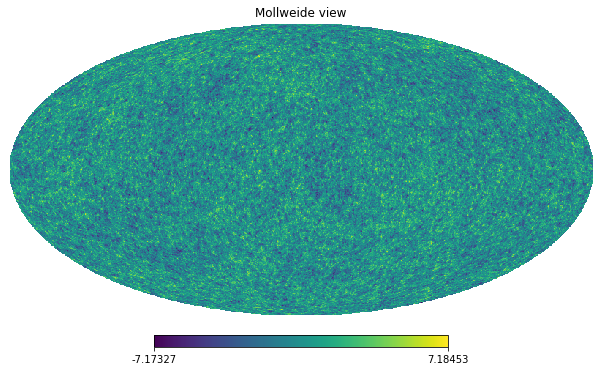

In [12]:
seed = 589
np.random.seed(seed)

alm = hp.synalm((cl), lmax=lmax, new=True)
nside=1024

hmap=hp.alm2map(alm, nside=nside, lmax=lmax)

hp.mollview(hmap)

Calculating the power spectrum from the map

In [9]:
rcl=hp.anafast(hmap,lmax=lmax,use_pixel_weights=True)

rdl=ell * (ell + 1.) * rcl/(np.pi*2)

Text(0, 0.5, '$\\frac{\\ell(\\ell+1)}{2\\pi}C_{\\ell}$')

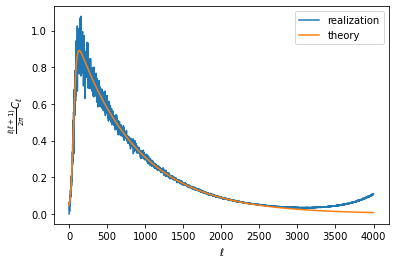

In [10]:
plt.plot(ell,rdl ,label='realization')
plt.plot(ell,dl,label='theory')
plt.legend()
plt.xlabel("$\ell$")
plt.ylabel(r"$\frac{\ell(\ell+1)}{2\pi}C_{\ell}$")

Text(0, 0.5, '$ln(D_l)$')

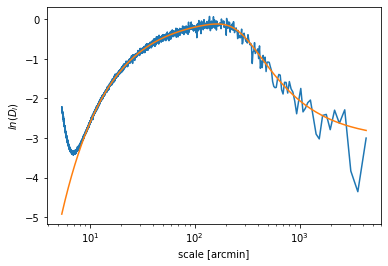

In [11]:
ellsc=21600/ell
ellsc=ellsc[::-1]

fdl=rdl[::-1]
tfdl=dl[::-1]

plt.plot(ellsc[:-5],np.log(fdl[:-5]),label='realization')
plt.plot(ellsc[:-5],np.log(tfdl[:-5]),label='theory')

plt.xlabel('scale [arcmin]')
plt.xscale('log')
plt.ylabel('$ln(D_l)$')

resolution of the map

In [17]:
nside=hp.npix2nside(len(hmap))
resarc=hp.nside2resol(nside,arcmin=True)
resol=hp.nside2resol(nside)
print("resolution = %.2f arcmin" % resarc)
print (resol)
print (nside)


resolution = 3.44 arcmin
0.0009993424882289927
1024


<font size="5">Defining the Wavelets</font>

These are the radial profile of the wavelet in real space

In [58]:
def gabor(f,sigma,theta):
    x=theta/np.sqrt(2)
    y=theta/np.sqrt(2)
    g=(np.exp(f*(x+y)*1.0j)*np.exp(-(x**2+y**2)/(2*sigma**2)))/(2*np.pi*sigma**2)
    return g



In [59]:
def morlet(f,sigma,theta):
    wv=gabor(f,sigma,theta)
    wvm=gabor(0,sigma, theta)
    B=np.sum(wv)/np.sum(wvm)
    #B = np.exp (-(f*sigma)**2)
    mor=wv-B*wvm
    return mor

# B

The wavelets in the spherical harmonic space

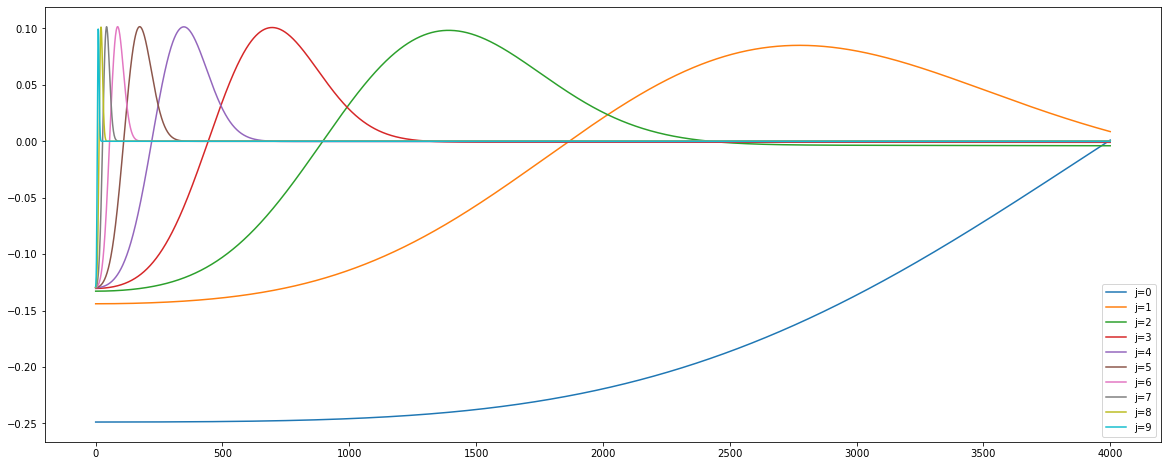

In [60]:
theta=np.linspace(0,np.pi,5000)
fig=plt.figure(figsize=[20,8])
for j in range(10):
    sigma1 = (0.8*resol*2**j)
    freq1=(3.0*np.pi) /(4.0*resol*2**j)

    mor=morlet(freq1,sigma1,theta)
    mor_l=hp.beam2bl(mor,theta,lmax=lmax)

    plt.plot(ell,mor_l,label='j='+str(j))
    plt.legend()

<font size="5">Scattering Transform</font>

Implementing the transform.

Wavelet description:

$\sigma = 0.8 \times 2^j$

$k = \frac{3\pi}{4 \times 2^j}$

Transform steps

Map = $I_0$

$\psi_1$ = set of filters corresponding to $j_1$

$\psi_2$ = set of filters corresponding to $j_2$

$\phi_1$ = Gaussian filter correspoding to $j_1$

$\phi_2$ = Gaussian filter correspoding to $j_2$

1. $I_1 = |I_0 \star \psi_1|$
2. $S_1 = \langle I_1 \star \phi_1 \rangle$
3. $I_2 = |I_1 \star \psi_2|$
4. $S_2 = \langle I_2 \star \phi_2 \rangle$


In [42]:
%%time

theta=np.linspace(0,np.pi,5000)

S1=np.zeros((10))
S2=np.zeros((10,10))

for j1 in range(10):
    
    sigma1 = (0.8*resol*2**j1) # multiplied by resolution in radians
    freq1=(3.0*np.pi) /(4.0*resol*2**j1) #divided by resolution in radians
    
    #filter 1
    mor=morlet(freq1,sigma1,theta)
    mor_l=hp.beam2bl(mor,theta,lmax=lmax) 
    
    #convolving the map with filter 1
    mapalm=hp.map2alm(hmap,lmax=lmax,use_pixel_weights=True)
    nalm=hp.almxfl(mapalm,mor_l)
    I1=hp.alm2map(nalm,nside,lmax)
    
    #modulus
    I1=np.abs(I1)
    
    #Gaussian filter for S1
    phi1=gabor(0,sigma1, theta)
    gab_l=hp.beam2bl(phi1,theta,lmax=lmax)
    
    #Convolving with gaussian filter to get S1
    I1alm=hp.map2alm(I1,lmax=lmax,use_pixel_weights=True)
    nI1alm=hp.almxfl(I1alm,gab_l)
    S1map=hp.alm2map(nI1alm,nside,lmax)
    
    #Averaging the entire map
    S1[j1]=np.mean(S1map)
    
    for j2 in range (10):
        
        sigma2 = (0.8*resol*2**j2)
        freq2=(3.0*np.pi) /(4.0*resol*2**j2)
        
        #filter 2        
        mor2=morlet(freq2,sigma2,theta)
        mor_l2=hp.beam2bl(mor2,theta,lmax=lmax)
        
        #Convolving I1 with filter 2
        mapalm2=hp.map2alm(I1,lmax=lmax,use_pixel_weights=True)
        nalm2=hp.almxfl(mapalm2,mor_l2)
        I2=hp.alm2map(nalm2,nside,lmax)
        
        #modulus
        I2=np.abs(I2)
        
        #Gaussian filter to get S2
        phi2=gabor(0,sigma2, theta)
        gab_l2=hp.beam2bl(phi2,theta,lmax=lmax)
    
        #Convolving with gaussian filter to get S2
        I2alm=hp.map2alm(I2,lmax=lmax,use_pixel_weights=True)
        nI2alm=hp.almxfl(I2alm,gab_l2)
        S2map=hp.alm2map(nI2alm,nside,lmax)     
                       
        #averaging the entire map
        S2[j1][j2]=np.mean(S2map)

KeyboardInterrupt: 

In [65]:
%%time

theta=np.linspace(0,np.pi,5000)

S1=np.zeros((10))

for j1 in range(10):
    
    sigma1 = (1*resol*2**j1) # multiplied by resolution in radians
    freq1=(3.0*np.pi) /(4.0*resol*2**j1) #divided by resolution in radians
    
    #filter 1
    mor=morlet(freq1,sigma1,theta)
    mor_l=hp.beam2bl(mor,theta,lmax=lmax) 
    
    #convolving the map with filter 1
    mapalm=hp.map2alm(hmap,lmax=lmax,use_pixel_weights=True)
    nalm=hp.almxfl(mapalm,mor_l)
    I1=hp.alm2map(nalm,nside,lmax)
    
    #modulus
    I1=np.abs(I1)
    
    
    
    #Gaussian filter for S1
    #phi1=gabor(0,sigma1, theta)
    #gab_l=hp.beam2bl(phi1,theta,lmax=lmax)
    
    #Convolving with gaussian filter to get S1
    #I1alm=hp.map2alm(I1,lmax=lmax,use_pixel_weights=True)
    #nI1alm=hp.almxfl(I1alm,gab_l)
    #S1map=hp.alm2map(nI1alm,nside,lmax)
    
    
    #Averaging the entire map
    S1[j1]=np.mean(I1)
    

CPU times: user 5min 1s, sys: 2.15 s, total: 5min 3s
Wall time: 1min 27s


Text(0.5, 1.0, 'S1 coefficients')

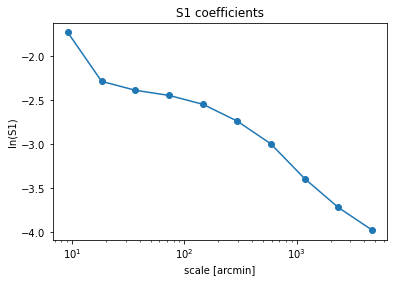

In [66]:
Jf=np.arange(10)
scale=2**Jf*((2*resarc)/0.75)
plt.plot(scale,np.log(S1),marker='o')
plt.xscale('log')
plt.xlabel("scale [arcmin]")
plt.ylabel("ln(S1)")
plt.title("S1 coefficients")

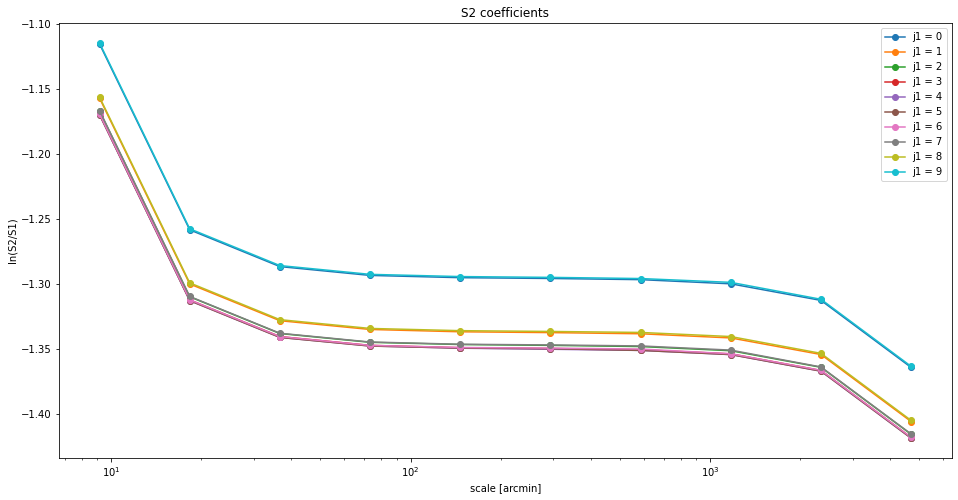

In [38]:
fig=plt.figure(figsize=[16,8])
for j in range (10):
    plt.plot(scale,np.log(S2[j]/S1[j]),marker='o',label="j1 = "+str(j))
    plt.xscale('log')
    plt.xlabel("scale [arcmin]")
    plt.legend(loc='best')
    plt.ylabel("ln(S2/S1)")
    plt.title("S2 coefficients")